In [1]:
# IMPORTACION DE LIBRERIAS
import numpy as np
import pandas as pd

# LIBRERIAS PARA HACER GRAFICOS
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as xp
from matplotlib import style
from mlxtend.plotting import plot_decision_regions

# PREPROCESADO, MODELADO y VALLIDACIÓN 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


# IGNORAMOS LOS WARNING
import warnings
warnings.filterwarnings('ignore')

# ESTILO DE LOS GRÁFICOS
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['axes.titlesize'] = "10"
style.use('ggplot') or plt.style.use('ggplot')

plt_colors = list(sns.color_palette().as_hex())

def plt_color(i):
    return plt_colors[i % len(plt_colors)]

In [2]:
# CARGA Y LIMPIEZA DE DATOS BÁSICO

! [ -f ASI_casoPractico.csv ] || wget https://raw.githubusercontent.com/tuxsy/iebs-master-data-science/main/m04/c2/sprint/ASI_casoPractico.csv

# Cargar el dataset
data = pd.read_csv("ASI_casoPractico.csv", sep=";")

# Eliminar columnas innecesarias
data = data.drop(["ID","b","e","DR"], axis = 1)

data.info()

--2023-02-01 09:41:35--  https://raw.githubusercontent.com/tuxsy/iebs-master-data-science/main/m04/c2/sprint/ASI_casoPractico.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167523 (164K) [text/plain]
Saving to: ‘ASI_casoPractico.csv’

ASI_casoPractico.cs 100%[===================>] 163.60K  --.-KB/s    in 0.02s   

2023-02-01 09:41:35 (6.83 MB/s) - ‘ASI_casoPractico.csv’ saved [167523/167523]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   int64  
 1   AC        2126 non-null   int64  
 2   FM        2126 non-null   int64  
 3   UC        2126 non-null   int64  
 4   ASTV      2126 non-nu

In [3]:
# ENCONTRAR UNA BUENA SEMILLA

X = data.loc[:, data.columns != "Target"]
y = data.loc[:, data.columns == "Target"]

# Fuerza bruta
# Calculamos el AUC para semillas entre [0, 500) y test_size entre [0.3, 0.9)
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

scores = []
gnb = GaussianNB()

for seed in tqdm(range(0, 500)):
  # for i in range(3,9):
  #   ts = i / 10
    ts = 0.4
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts , random_state = seed)

    modelNB = gnb.fit(X_train, y_train.values.ravel())
    y_pred_train = modelNB.predict_proba(X_train) 
    y_pred_test = modelNB.predict_proba(X_test)

    auc_train = roc_auc_score(y_train.values.ravel(), y_pred_train[:,1])
    auc_test = roc_auc_score(y_test.values.ravel(), y_pred_test[:,1])

    scores.append((ts, seed, auc_train, auc_test))

# Buscar la mejor combinación de test-size y seed con estos dos objetivos en mente
# - Minimiza el sobre-ajuste
# - Maximizar el área bajo la curva con los datos de entrenamiento

df_scores = pd.DataFrame(data=scores, columns=["test_size", "seed", "auc_train", "auc_test"])

# Me invento una métrica llamada "performance"
# - performance = auc_test * (1 - abs(auc_train - auc_test))

# Esta métrica funciona del siguiente modo
# - cuanto mayor es auc_test mejor es performance
# - cuanto mayor es el sobreajuste (auc_train - auc_test) peor es performance

# Calculamos la métrica
df_scores["performance"] = df_scores.auc_test * (1 - np.abs(df_scores.auc_train - df_scores.auc_test))

# Estimamos el sobreajuste para cada test_size y semila

df_scores["overfit_est"] = np.abs(df_scores.auc_train - df_scores.auc_test)

# # Obtenemos la mejor combinación
aux = df_scores.nlargest(3, "performance").reset_index()
best_ts = aux.loc[0,"test_size"]
best_seed = aux.loc[0,"seed"]
print(f"test_size={best_ts}; seed={best_seed}")
aux

  0%|          | 0/500 [00:00<?, ?it/s]

test_size=0.4; seed=124


,index,test_size,seed,auc_train,auc_test,performance,overfit_est
0,124,0.4,124,0.950311,0.954030,0.950482,0.003720
1,50,0.4,50,0.950070,0.950021,0.949975,0.000048
2,59,0.4,59,0.949149,0.952617,0.949313,0.003469


In [4]:
# MUESTREO
X = data.loc[:, data.columns != "Target"]
y = data.loc[:, data.columns == "Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = best_ts, random_state = best_seed)

In [5]:
# ENTRENAMIENTO NAIVE BAYES
gnb = GaussianNB()

modelNB = gnb.fit(X_train, y_train.values.ravel())
y_pred_train_nb = modelNB.predict_proba(X_train) 
y_pred_test_nb = modelNB.predict_proba(X_test)

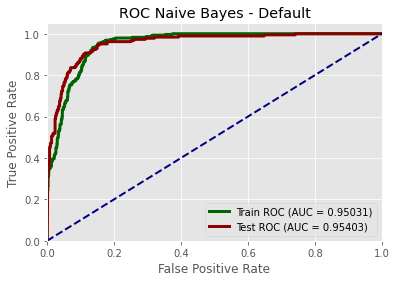

In [6]:
# VALIDACIÓN
#
# Encapsulamos la generación de la curva ROC en una función reutilizable
#
def plot_ROC(y_train, y_test, pred_train, pred_test, title="ROC"):
  # CURVA ROC Y AUC PARA TRAINING
  fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
  roc_auc_train = auc(fpr_train, tpr_train)

  # CURVA ROC Y AUC PARA TEST
  fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
  roc_auc_test = auc(fpr_test, tpr_test)

  # GRAFICA
  plt.figure()
  lw = 2

  plt.plot(fpr_train,tpr_train,color="darkgreen",lw=lw+1,label="Train ROC (AUC = %0.5f)" % roc_auc_train,)
  plt.plot(fpr_test,tpr_test,color="darkred",lw=lw+1,label="Test ROC (AUC = %0.5f)" % roc_auc_test,)

  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

plot_ROC(
    y_train=y_train,
    y_test=y_test,
    pred_train=y_pred_train_nb,
    pred_test=y_pred_test_nb,
    title="ROC Naive Bayes - Default"
)